# Probabalistic fiber tracking  

Probabilistic fiber tracking follows the trajectory of a possible pathway step by step starting at a seed, however, unlike deterministic tracking, the tracking direction at each point along the path is chosen at random from a distribution. The distribution at each point is different and depends on the observed diffusion data at that point. The distribution of tracking directions at each point can be represented as a probability mass function (PMF) if the possible tracking directions are restricted to discrete numbers of well distributed points on a sphere.

In [5]:
# Use subprocess.check_call to install missing libraries
import subprocess
# subprocess.check_call(["python", "-m", "pip", "install", "opencv-python"])

In [3]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import cv2 as cv

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.reconst.csdeconv import (ConstrainedSphericalDeconvModel,
                                   auto_response_ssst)
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.viz import window, actor, colormap, has_fury
from dipy.direction import ProbabilisticDirectionGetter
from dipy.data import small_sphere
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_trk
from dipy.data import default_sphere
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model


def imsh(img,title,nrows=1,ncols=1,cmap='gray'):
    fig,ax=plt.subplots(nrows=nrows,ncols=ncols,
    figsize=(8,8))
    plt.title(title, fontsize=22)
    ax.imshow(img,cmap='gray')
    ax.axis('off')
    return fig,ax

# Enables/disables interactive visualization
interactive = False

hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
gtab = gradient_table(bvals, bvecs)

seed_mask = (labels == 2)
white_matter = (labels == 1) | (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=1)

response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csd_model = ConstrainedSphericalDeconvModel(gtab, response, sh_order=6)
csd_fit = csd_model.fit(data, mask=white_matter)

csa_model = CsaOdfModel(gtab, sh_order=6)
gfa = csa_model.fit(data, mask=white_matter).gfa
stopping_criterion = ThresholdStoppingCriterion(gfa, .25)

Use probability mass function (PMF) to represent possible tracking directions.

In [11]:
fod = csd_fit.odf(small_sphere)
pmf = fod.clip(min=0)
prob_dg = ProbabilisticDirectionGetter.from_pmf(pmf, max_angle=30.,
                                                sphere=small_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_probabilistic_dg_pmf.trk")

if has_fury:
    scene = window.Scene()
    scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
    window.record(scene, out_path='tractogram_probabilistic_dg_pmf.png',
                  size=(800, 800))
exit()

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5257be2f40>)

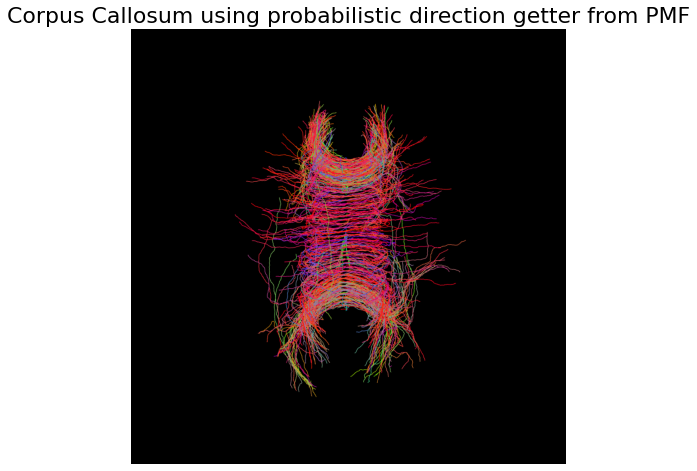

In [7]:
pmf=cv.imread('tractogram_probabilistic_dg_pmf.png')
pmf=cv.cvtColor(pmf,cv.COLOR_BGR2RGB)
imsh(pmf,'Corpus Callosum using probabilistic direction getter from PMF')

An issue with PMF is the tendency to take up a lot of memory (RAM). A solution is to build the direction getter directly from the spherical harmonic (SH) representation of the Fiber Orientation Distribution (FOD) of the Constrained Spherical Deconvolution (CSD) model.

In [21]:
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(csd_fit.shm_coeff,
                                                    max_angle=30.,
                                                    sphere=default_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_probabilistic_dg_sh.trk")

if has_fury:
    scene = window.Scene()
    scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
    window.record(scene, out_path='tractogram_probabilistic_dg_sh.png',
                  size=(800, 800))
    if interactive:
        window.show(scene)
exit()

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3605b1bb20>)

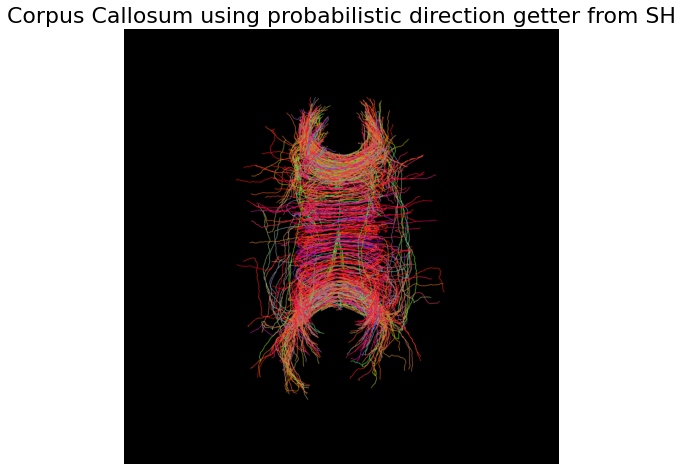

In [6]:
pmf=cv.imread('tractogram_probabilistic_dg_sh.png')
pmf=cv.cvtColor(pmf,cv.COLOR_BGR2RGB)
imsh(pmf,'Corpus Callosum using probabilistic direction getter from SH')

Not all models use the SM coefficient to represent data internally. A solution to this is to fit the orientation distribution function (ODF) of any model to the SH basis with the peaks_from_model function.

In [3]:
peaks = peaks_from_model(csd_model, data, default_sphere, .5, 25,
                         mask=white_matter, return_sh=True, parallel=True)
fod_coeff = peaks.shm_coeff

prob_dg = ProbabilisticDirectionGetter.from_shcoeff(fod_coeff, max_angle=30.,
                                                    sphere=default_sphere)
streamline_generator = LocalTracking(prob_dg, stopping_criterion, seeds,
                                     affine, step_size=.5)
streamlines = Streamlines(streamline_generator)
sft = StatefulTractogram(streamlines, hardi_img, Space.RASMM)
save_trk(sft, "tractogram_probabilistic_dg_sh_pfm.trk")

if has_fury:
    scene = window.Scene()
    scene.add(actor.line(streamlines, colormap.line_colors(streamlines)))
    window.record(scene, out_path='tractogram_probabilistic_dg_sh_pfm.png',
                  size=(800, 800))
    if interactive:
        window.show(scene)
exit()

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0f8916a370>)

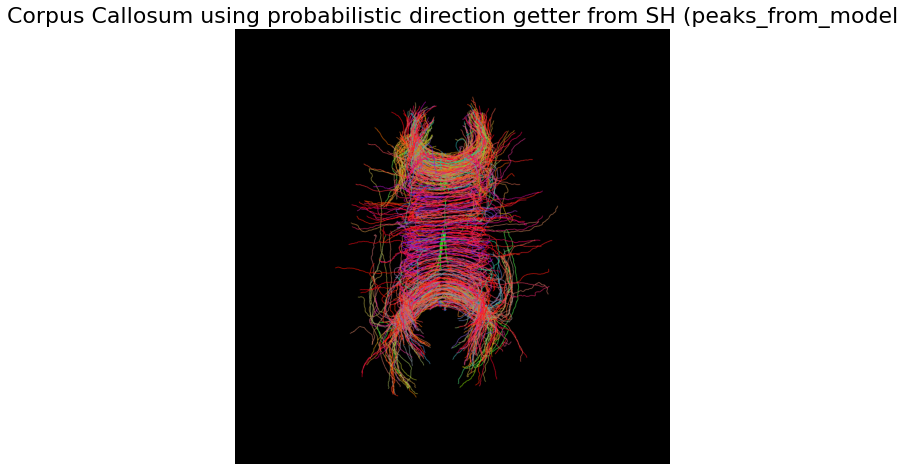

In [4]:
pmf=cv.imread('tractogram_probabilistic_dg_sh_pfm.png')
pmf=cv.cvtColor(pmf,cv.COLOR_BGR2RGB)
imsh(pmf,'Corpus Callosum using probabilistic direction getter from SH (peaks_from_model')